In [2]:
import SpatialDE

import numpy as np
import scipy
import pandas as pd
import scanpy as sc
import anndata as ad

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
from plotnine import *
import mizani

theme_set(theme_bw())
theme_update(legend_key=element_blank(),
             text=element_text(family="Helvetica"),
             axis_text=element_text(color="black"),
             panel_border=element_rect(color="black"),
             strip_background=element_rect(color="black")
            )

from io import StringIO
from itertools import chain
from bioservices import BioMart, UniProt
import goatools

In [3]:
a30_0 = sc.read_visium("152807")
a30_0.var_names_make_unique()
a30_0.var["mt"] = a30_0.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(a30_0, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/kats/.local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.


In [4]:
sc.pp.filter_cells(a30_0, min_counts=800)
a30_0 = a30_0[a30_0.obs["pct_counts_mt"] < 20]
sc.pp.filter_genes(a30_0, min_cells=100)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Trying to set attribute `.var` of view, copying.


In [5]:
s = BioMart()
s.add_dataset_to_xml("hsapiens_gene_ensembl")
s.add_attribute_to_xml("ensembl_gene_id")
s.add_attribute_to_xml("external_gene_name")
s.add_attribute_to_xml("entrezgene_accession")
s.add_attribute_to_xml("entrezgene_id")

s.add_filter_to_xml("ensembl_gene_id", ",".join(a30_0.var.gene_ids.to_numpy()))
res = s.query(s.get_xml())
res = pd.read_table(StringIO(res), names=["ensembl_gene_id", "gene_name", "entrezgene_accession", "entrezgene_id"], dtype={"entrezgene_id": pd.Int32Dtype()})

def filter_entrez(group):
    group = group.drop("ensembl_gene_id", axis=1)
    if group.shape[0] == 1:
        ret = group.iloc[0,:]
    else:
        matched = group[group.gene_name == group.entrezgene_accession]
        ret = matched.iloc[0,:] # no clear way to choose if there are multiple matches, so I just choose the first one
    return ret.drop("entrezgene_accession")
res = res.dropna().reset_index(drop=True).groupby("ensembl_gene_id").apply(filter_entrez)

a30_0.var["entrez_id"] = (
    a30_0.var.
    reset_index().
    rename(columns={"index":"gene_name", "gene_ids": "ensembl_gene_id"}).
    merge(
        res.assign(entrezgene_id=res.entrezgene_id.astype(pd.Int32Dtype())),
        on=["gene_name", "ensembl_gene_id"]).
    set_index("gene_name").
    rename_axis(index=None)["entrezgene_id"]
)

In [ ]:
svg_full, _ = SpatialDE.test(a30_0, omnibus=True)
svg_full["total_counts"] = np.asarray(a30_0.X.sum(axis=0)).squeeze()
svg_full.to_pickle("152807_svg_full.pkl")

In [6]:
svg_full = pd.read_pickle("152807_svg_full.pkl")

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'feature_types' as categorical
... storing 'genome' as categorical


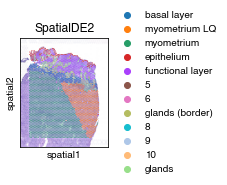

In [7]:
vargenes = svg_full[svg_full.padj < 0.001].sort_values("total_counts", ascending=False).gene[:2000]
segm, _ = SpatialDE.tissue_segmentation(a30_0, genes=vargenes, rng=np.random.default_rng(seed=42))
region_mapping = {0:"basal layer", 1: "myometrium LQ", 2: "myometrium", 3: "epithelium", 4: "functional layer", 7: "glands (border)", 11: "glands"}
a30_0.obs["segmentation_labels_names"] = a30_0.obs.segmentation_labels.cat.rename_categories(region_mapping)

with rc_context({"figure.figsize": (2,2)}):
    sc.pl.spatial(a30_0, color="segmentation_labels_names", title="SpatialDE2", return_fig=True).savefig("figures/4a_spatialde.svg", dpi=1000)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


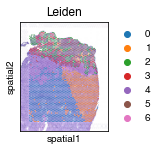

In [8]:
a30_0_normalized = a30_0.copy()
sc.pp.normalize_total(a30_0_normalized, target_sum=1e4, key_added="scaling_factor")
a30_0_norm_reg = a30_0_normalized.copy()
sc.pp.log1p(a30_0_norm_reg)
a30_0_norm_reg = a30_0_norm_reg[:, vargenes]
sc.pp.regress_out(a30_0_norm_reg, ['total_counts'])
sc.pp.scale(a30_0_norm_reg, max_value=10)
sc.tl.pca(a30_0_norm_reg, svd_solver='arpack')
sc.pp.neighbors(a30_0_norm_reg, n_neighbors=10, n_pcs=50)
sc.tl.leiden(a30_0_norm_reg, random_state=42, resolution=0.6)
with rc_context({"figure.figsize": (2,2)}):
    sc.pl.spatial(a30_0_norm_reg, color="leiden", title="Leiden", return_fig=True).savefig("figures/4a_leiden.svg", dpi=1000)

In [9]:
resolutions = (0.1, 0.3, 0.6, 0.8, 1., 1.5, 2.)
smoothnesses = (0.5, 1., 2., 3., 5., 8., 10.)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


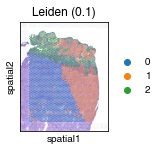

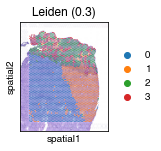

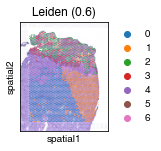

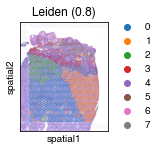

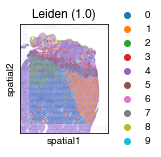

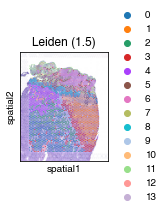

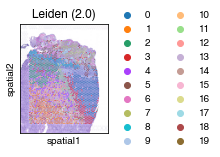

In [10]:
a30_0_norm_reg.obs["leiden_0.6"] = a30_0_norm_reg.obs.leiden
with rc_context({"figure.figsize": (2, 2)}):
    for res in resolutions:
        sc.tl.leiden(a30_0_norm_reg, random_state=42, resolution=res, key_added=f"leiden_{res}")
        sc.pl.spatial(a30_0_norm_reg, color=f"leiden_{res}", return_fig=True, title=f"Leiden ({res})").savefig(f"figures/s4d_{res}.svg", dpi=1000)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


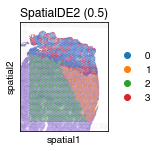

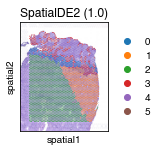

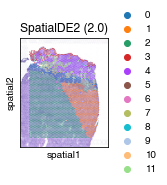

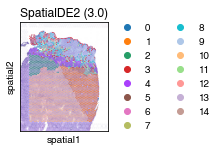

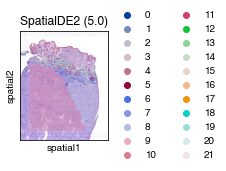

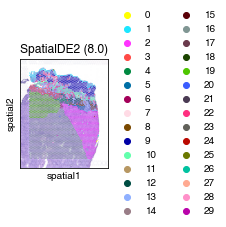

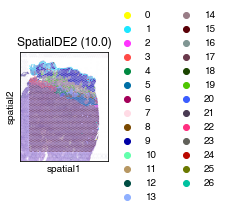

In [11]:
testdata = a30_0.copy()
with rc_context({"figure.figsize": (2, 2)}):
    for smoothness in smoothnesses:
        segm_adj, _ = SpatialDE.tissue_segmentation(testdata, genes=vargenes, rng=np.random.default_rng(seed=42), params=SpatialDE.TissueSegmentationParameters(smoothness_factor=smoothness))
        sc.pl.spatial(testdata, color=f"segmentation_labels", return_fig=True, title=f"SpatialDE2 ({smoothness})").savefig(f"figures/s4c_{smoothness}.svg", dpi=1000)

In [12]:
ulabels, lcounts = np.unique(segm.labels, return_counts=True)

In [ ]:
svg_byregion = []
for l in ulabels[lcounts > 100]:
    res, _ = SpatialDE.test(a30_0[segm.labels == l, :], omnibus=True)
    res["label"] = l
    svg_byregion.append(res)
svg_byregion = pd.concat(svg_byregion, axis=0, ignore_index=True)
svg_byregion.to_pickle("15807_svg_byregion.pkl")

In [13]:
svg_byregion = pd.read_pickle("15807_svg_byregion.pkl")
(
    ggplot(svg_byregion.
               assign(region=lambda x: pd.Categorical(x.label).rename_categories(region_mapping))[svg_byregion.padj < 0.001],
           aes("region")) +
        geom_bar() +
        ylab("spatially variable genes") +
        theme(axis_text_x=element_text(rotation=20, ha="right"), figure_size=(3, 2))
).save("figures/4b.svg")

/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 3 x 2 in image.
/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/4b.svg


In [8]:
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag(obo_fname)
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
ns2assoc = objanno.get_ns2assc()
background_genes = a30_0.var.entrez_id.to_numpy()
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
goeaobj = GOEnrichmentStudyNS(background_genes, ns2assoc, obodag, propagate_counts=False, alpha=0.01, methods=['fdr_by'])
go_enrichment = []
for label, g in svg_byregion.groupby("label"):
    enrichment = goeaobj.run_study(a30_0.var.entrez_id[g.gene[g.padj < 0.001]].to_numpy().tolist(), prt=None)
    res = []
    for term in enrichment:
        res.append({
            "ont": term.NS,
            "go": term.GO,
            "desc": term.name,
            "study_count": term.study_count,
            "population_count": term.pop_count,
            "study_ratio": np.divide(*term.ratio_in_study),
            "population_ratio": np.divide(*term.ratio_in_pop),
            "pval": term.p_uncorrected,
            "padj": term.p_fdr_by,
            "label": label,
            "genes": a30_0.var.query("entrez_id in @term.study_items").index.to_numpy()
        })
    go_enrichment.append(pd.DataFrame(res))
go_enrichment = pd.concat(go_enrichment, axis=0, ignore_index=True).assign(label=lambda x: pd.Categorical(x.label))

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-10-09) 47,313 GO Terms
HMS:0:00:03.552324 339,786 annotations, 20,620 genes, 18,417 GOs, 1 taxids READ: gene2go 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 87% 10,524 of 12,150 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 90% 10,975 of 12,150 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 89% 10,823 of 12,150 population items found in association


In [20]:
go_enrichment["region"] = go_enrichment.label.cat.rename_categories(region_mapping)
(
    ggplot(go_enrichment[(go_enrichment.padj < 1e-2) & (go_enrichment.ont == "BP")].assign(
            label=lambda x: np.where(x.go.isin(("GO:0010273", "GO:0006882", "GO:0071294", "GO:0071280", "GO:0071276")), x.desc, x.go)),
        aes("region", "label", color="-np.log10(pval)", size="study_ratio")) +
    geom_point() +
    facet_wrap("ont", ncol=1, scales="free") +
    labs(size="fraction of sample", color=r"$-\log_{10}(p)$", y=None, x=None) + 
    theme(figure_size=(2.5,5), subplots_adjust={'hspace': 0.2}, axis_text_x=element_text(rotation=30, ha="right"))
).save("figures/4c.svg")

/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 2.5 x 5 in image.
/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/4c.svg


/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


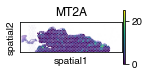

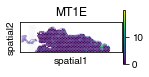

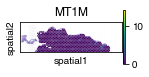

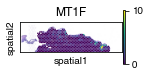

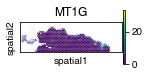

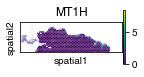

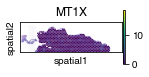

In [15]:
with rc_context({"figure.figsize": (2, 1)}):
    for gene in ("MT2A", "MT1E", "MT1M", "MT1F", "MT1G", "MT1H", "MT1X"):
        sc.pl.spatial(a30_0_normalized, color=gene, size=1.5, crop_coord=[0, 1000, 1500, 1200], return_fig=True).savefig(f"figures/4d_{gene}.svg", dpi=1000)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


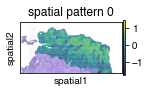

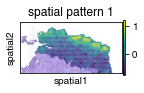

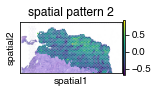

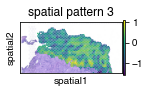

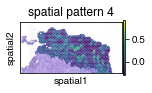

In [16]:
allsignifgenes = svg_full[svg_full.padj < 0.001].gene.to_numpy()
upper_patterns, upper_a30_0 = SpatialDE.spatial_patterns(a30_0[np.isin(segm.labels, (0, 3,4,7,8,9,11)),:], genes=allsignifgenes, rng=np.random.default_rng(seed=42), copy=True)
with rc_context({"figure.figsize": (2,1)}):
    for i in range(upper_patterns.patterns.shape[1]):
        sc.pl.spatial(upper_a30_0, color=f"spatial_pattern_{i}", title=f"spatial pattern {i}", crop_coord=[0, 1000, 1500, 1000], size=1.5, return_fig=True).savefig(f"figures/4e_pattern_{i}.svg", dpi=1000)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


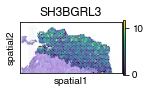

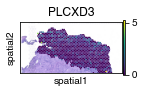

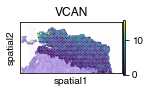

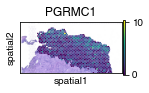

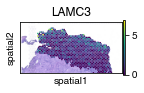

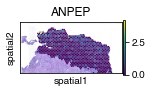

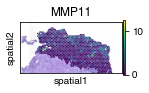

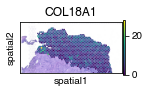

In [17]:
upper_a30_0_normalized = a30_0_normalized[np.isin(segm.labels, (0, 3,4,7,8,9,11)),:]
with rc_context({"figure.figsize": (2,1)}):
    for gene in allsignifgenes[upper_patterns.labels == 1]:
        sc.pl.spatial(upper_a30_0_normalized, color=gene, size=1.5, crop_coord=[0, 1000, 1500, 1000], return_fig=True).savefig(f"figures/4e_{gene}.svg", dpi=1000)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


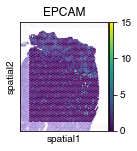

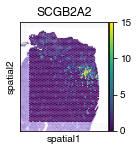

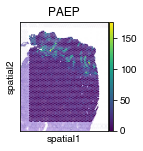

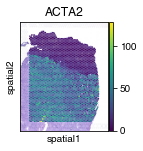

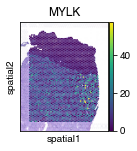

In [18]:
with rc_context({"figure.figsize":(2,2)}):
    for gene, vmax in zip(["EPCAM", "SCGB2A2", "PAEP", "ACTA2", "MYLK"], (15, 15, None, None, None)):
        sc.pl.spatial(a30_0_normalized, return_fig=True, color=gene, size=1.5, vmax=vmax).savefig(f"figures/s4b_{gene}.svg", dpi=1000)

In [14]:
rnakeys = ("q05_nUMI_factors", "mean_nUMI_factors", "q95_nUMI_factors")
weightkeys = ("q05_spot_factor", "mean_spot_factor", "q95_spot_factor")
cell2locationdata = ad.read_h5ad("20201207_LocationModelLinearDependentWMultiExperiment_19clusters_20952locations_19980genes/sp.h5ad")
cell2locationdata = cell2locationdata[cell2locationdata.obs["sample"] == "152807"]
a30_0_unfiltered = sc.read_visium("152807")
for key in chain(rnakeys, weightkeys):
    a30_0_unfiltered.obs = a30_0_unfiltered.obs.join(cell2locationdata.obs.set_index("spot_id").filter(like=key), sort=False)

/home/kats/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
a30_0_celltypernas = tuple(a30_0_unfiltered.obs.filter(like=k) for k in rnakeys)
a30_0_celltypeads = tuple(ad.AnnData(X=ctr.to_numpy().round().astype(np.int32), obs=pd.DataFrame(index=a30_0_unfiltered.obs_names), var=pd.DataFrame(index=ctr.columns), uns=a30_0_unfiltered.uns, obsm=a30_0_unfiltered.obsm) for ctr in a30_0_celltypernas)

In [16]:
slabs = a30_0.obs.segmentation_labels_names[a30_0.obs.segmentation_labels.isin((0, 4,7, 11))]
obs = a30_0_celltypeads[1].obs.loc[slabs.index,:]
obs["segmentation_labels_names"] = slabs
(
    ggplot(obs.
               join(pd.DataFrame(a30_0_celltypeads[1].X, columns=a30_0_celltypeads[1].var_names.str[17:], index=a30_0_celltypeads[1].obs_names)).
               reset_index().
               melt(id_vars=["segmentation_labels_names", "index"], var_name="celltype", value_name="mean_spot_factor").
               assign(segmentation_labels_names=lambda df: df.segmentation_labels_names.cat.remove_unused_categories()).
               groupby("index").
               apply(lambda g: g.assign(rel_mean_spot_factor=lambda g: g.mean_spot_factor / g.mean_spot_factor.sum())),
           aes("celltype", "rel_mean_spot_factor", color="segmentation_labels_names")) +
        geom_sina(scale="width", shape=".", alpha=0.6, size=0.01) +
        labs(x=None, y="fraction of transcripts") +
        guides(color=guide_legend(title="", override_aes={"alpha": 1, "shape": 'o', "size": 2})) +
      theme(figure_size=(10, 2), axis_text_x=element_text(rotation=30, ha="right"))
).save("figures/s4a.svg")

/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 2 in image.
/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/s4a.svg


In [17]:
c2l_segm, _ = SpatialDE.tissue_segmentation(a30_0_celltypeads[1], rng=np.random.default_rng(seed=42))

/home/kats/SpatialDE_old/Python-module/SpatialDE/dp_hmrf.py:172: RuntimeWarning: Neither genes nor sizefactors are given. Assuming that adata contains complete data set, will calculate size factors and perform segmentation using the complete data set.


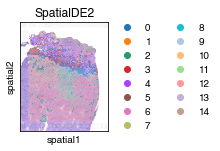

In [18]:
with rc_context({"figure.figsize": (2,2)}):
    sc.pl.spatial(a30_0_celltypeads[1], color="segmentation_labels", title="SpatialDE2", return_fig=True).savefig("figures/5a_spatialde.svg", dpi=1000)

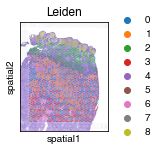

In [19]:
a30_0_celltypeweights = tuple(a30_0_unfiltered.obs.filter(like=k) for k in weightkeys)
a30_0_celltypeweightads = tuple(ad.AnnData(X=ctr.to_numpy(), obs=a30_0_unfiltered.obs, var=pd.DataFrame(index=ctr.columns), uns=a30_0_unfiltered.uns, obsm=a30_0_unfiltered.obsm) for ctr in a30_0_celltypeweights)

sc.pp.neighbors(a30_0_celltypeweightads[1], n_neighbors=10, n_pcs=0, random_state=42, metric="cosine")
sc.tl.leiden(a30_0_celltypeweightads[1], random_state=42, resolution=0.4)
with rc_context({"figure.figsize": (2,2)}):
    sc.pl.spatial(a30_0_celltypeweightads[1], color="leiden", title="Leiden", return_fig=True).savefig("figures/5a_leiden.svg", dpi=1000)

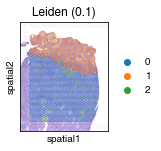

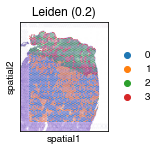

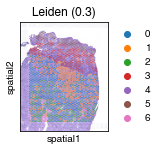

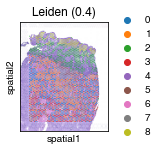

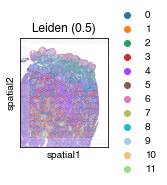

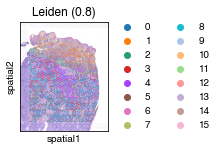

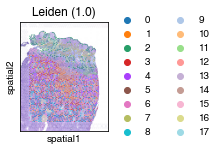

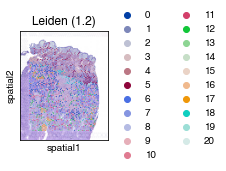

In [26]:
resolutions = (0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.2)
with rc_context({"figure.figsize": (2,2)}):
    for r in resolutions:
        sc.tl.leiden(a30_0_celltypeweightads[1], random_state=42, resolution=r, key_added=f"leiden_{r}")
        sc.pl.spatial(a30_0_celltypeweightads[1], color=f"leiden_{r}", title=f"Leiden ({r:.1f})", return_fig=True).savefig(f"figures/s5_leiden_resolution_{r:.1f}.svg", dpi=1000)

In [ ]:
a30_0_umap = a30_0.copy()
a30_0_umap.obs["segmentation_labels_c2l"] = a30_0_celltypeads[1].obs.segmentation_labels
sc.pp.highly_variable_genes(a30_0_umap, flavor="seurat_v3", n_top_genes=2000)
sc.pp.normalize_total(a30_0_umap, target_sum=1e4, inplace=True)
sc.pp.log1p(a30_0_umap)
sc.pp.regress_out(a30_0_umap, ['total_counts'])
sc.pp.scale(a30_0_umap, max_value=10)
sc.pp.pca(a30_0_umap, n_comps=10)
sc.pp.neighbors(a30_0_umap, n_neighbors=15)
sc.tl.umap(a30_0_umap, min_dist=0.5)

In [ ]:
with rc_context({"figure.figsize": (2,2)}):
    sc.pl.umap(a30_0_umap, color="segmentation_labels_c2l", groups=(1,5,8), size=10, title="", return_fig=True).savefig("figures/5b.svg")

In [ ]:
(
    ggplot(a30_0_celltypeads[1].obs.
               query("segmentation_labels in (1,5,8)").
               join(pd.DataFrame(a30_0_celltypeads[1].X, columns=a30_0_celltypeads[1].var_names.str[17:], index=a30_0_celltypeads[1].obs_names)).
               reset_index().
               melt(id_vars=["segmentation_labels", "index"], var_name="celltype", value_name="mean_spot_factor").
               assign(segmentation_labels=lambda df: df.segmentation_labels.cat.remove_unused_categories()).
               groupby("index").
               apply(lambda g: g.assign(rel_mean_spot_factor=lambda g: g.mean_spot_factor / g.mean_spot_factor.sum())),
           aes("celltype", "rel_mean_spot_factor", color="segmentation_labels")) +
        geom_sina(scale="width", shape=".", alpha=0.6, size=0.01) +
        labs(x=None, y="fraction of transcripts") +
        guides(color=guide_legend(title="", override_aes={"alpha": 1, "shape": 'o', "size": 2})) +
      theme(figure_size=(6, 2), axis_text_x=element_text(rotation=30, ha="right"))
).save("figures/5c.svg")

In [31]:
(
    ggplot(a30_0_celltypeads[1].obs.
               join(pd.DataFrame(a30_0_celltypeads[1].X, columns=a30_0_celltypeads[1].var_names.str[17:], index=a30_0_celltypeads[1].obs_names)).
               reset_index().
               melt(id_vars=["segmentation_labels", "index"], var_name="celltype", value_name="mean_spot_factor").
               assign(segmentation_labels=lambda df: df.segmentation_labels.cat.remove_unused_categories()).
               groupby("index").
               apply(lambda g: g.assign(rel_mean_spot_factor=lambda g: g.mean_spot_factor / g.mean_spot_factor.sum())),
           aes("celltype", "rel_mean_spot_factor", color="segmentation_labels")) +
        geom_sina(scale="width", shape=".", alpha=0.6, size=0.01) +
        labs(x=None, y="fraction of transcripts") +
        guides(color=guide_legend(title="", override_aes={"alpha": 1, "shape": 'o', "size": 2}, nrow=1)) +
      theme(figure_size=(15, 2), axis_text_x=element_text(rotation=30, ha="right"), legend_position="top")
).save("figures/5d.svg")

/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 15 x 2 in image.
/home/kats/.local/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/5d.svg
/home/kats/.local/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_sina : Removed 19 rows containing non-finite values.


In [54]:
with pd.ExcelWriter("figures/table_s_endometrium.xlsx") as ew:
    svg_full[["gene", "pval", "padj"]].to_excel(ew, sheet_name="SV genes whole slice", index=False)
    svg_byregion[["gene", "pval", "padj", "label"]].rename(columns={"label": "region"}).to_excel(ew, sheet_name="SV genes per region", index=False)
    go_enrichment.rename(columns={"region": "region_name", "label": "region"}).to_excel(ew, sheet_name="SV genes GO enrichment", index=False)
    a30_0.obs[["segmentation_labels", "segmentation_labels_names"]].reset_index().rename(columns={"index": "spatial_barcode", "segmentation_labels": "region", "segmentation_labels_names": "region_name"}).to_excel(ew, sheet_name="segmentation (counts)", index=False)
    a30_0_celltypeads[1].obs.reset_index().rename({"index": "spatial_barcode", "segmentation_labels": "region"}).to_excel(ew, sheet_name="segmentation (cell2location)", index=False)